## Lets create framework to test algorithms and prepare submissions

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import log_loss

def test_solution(classifier):
    np.random.seed(42)
    classifier.fit(X_train, y_train)
    return log_loss(y_test, classifier.predict(X_test))

In [3]:
def create_submission(classifier):
#     X = pd.read_csv('x_test.csv', sep=';')
    answer = classifier.predict(X)
    y = pd.DataFrame(answer)
    y.to_csv('submission.csv', header=None, index=False)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data(X, y):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return train_test_split(X, y)

## Data observation

In [5]:
X = pd.read_csv('x_train.csv', sep=';')
y = ravel(pd.read_csv('y_train.csv', header=None))

(array([ 18001.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   7288.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

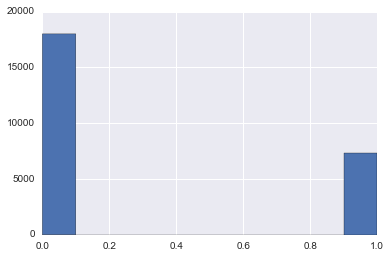

In [6]:
data = X.copy()
data['outcome'] = y

# hist(X['attemptsOnTheHighestLevel'], range=(10,100))
hist(data['outcome'])

In [7]:
data['outcome'].value_counts()

0    18001
1     7288
Name: outcome, dtype: int64

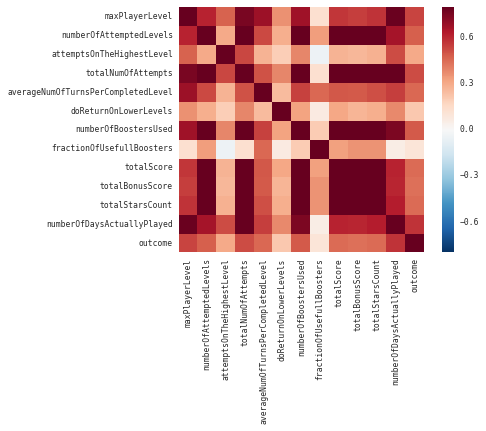

In [8]:
sns.set(context="paper", font="monospace")

corrmat = data.corr()
_ = sns.heatmap(corrmat, vmax=.8, square=True)

In [9]:
corrmat[corrmat > 0.9]

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed,outcome
maxPlayerLevel,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numberOfAttemptedLevels,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.979954,0.989014,0.993779,NaN,NaN
attemptsOnTheHighestLevel,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
totalNumOfAttempts,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
averageNumOfTurnsPerCompletedLevel,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doReturnOnLowerLevels,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numberOfBoostersUsed,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
fractionOfUsefullBoosters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
totalScore,NaN,0.979954,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.985111,0.986423,NaN,NaN
totalBonusScore,NaN,0.989014,NaN,NaN,NaN,NaN,NaN,NaN,0.985111,1.000000,0.997357,NaN,NaN


In [10]:
data.columns

Index([u'maxPlayerLevel', u'numberOfAttemptedLevels',
       u'attemptsOnTheHighestLevel', u'totalNumOfAttempts',
       u'averageNumOfTurnsPerCompletedLevel', u'doReturnOnLowerLevels',
       u'numberOfBoostersUsed', u'fractionOfUsefullBoosters', u'totalScore',
       u'totalBonusScore', u'totalStarsCount', u'numberOfDaysActuallyPlayed',
       u'outcome'],
      dtype='object')

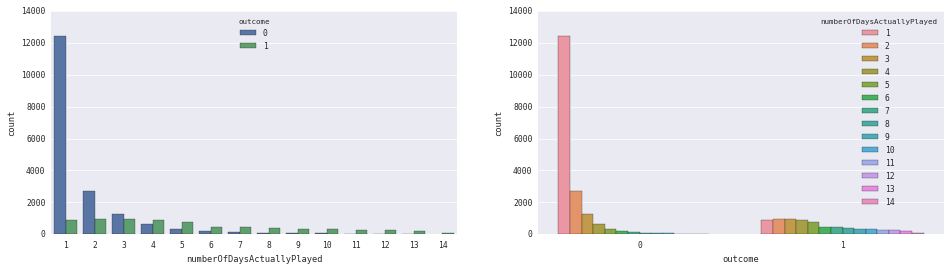

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=data, x='numberOfDaysActuallyPlayed',hue='outcome', ax=ax1)
sns.countplot(data=data, x='outcome',hue='numberOfDaysActuallyPlayed', ax=ax2)

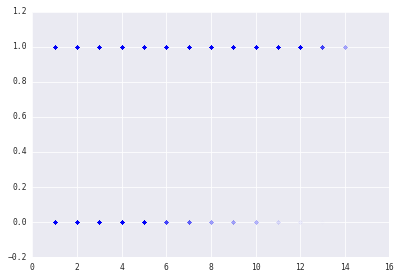

In [12]:
scatter(data['numberOfDaysActuallyPlayed'], data['outcome'],alpha=0.004)

In [13]:
from pandas.tools.plotting import scatter_matrix

# scatter_matrix(data, figsize=(100, 100), alpha=0.05)

In [14]:
data.columns

Index([u'maxPlayerLevel', u'numberOfAttemptedLevels',
       u'attemptsOnTheHighestLevel', u'totalNumOfAttempts',
       u'averageNumOfTurnsPerCompletedLevel', u'doReturnOnLowerLevels',
       u'numberOfBoostersUsed', u'fractionOfUsefullBoosters', u'totalScore',
       u'totalBonusScore', u'totalStarsCount', u'numberOfDaysActuallyPlayed',
       u'outcome'],
      dtype='object')

count    25289.000000
mean        13.330451
std          6.657224
min          0.000000
25%          8.400000
50%         14.555556
75%         17.720000
max         40.000000
Name: averageNumOfTurnsPerCompletedLevel, dtype: float64

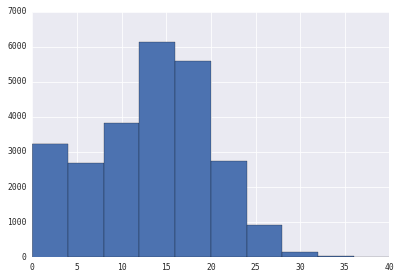

In [15]:
hist((data[u'averageNumOfTurnsPerCompletedLevel']))
(data[u'averageNumOfTurnsPerCompletedLevel']).describe()

## Baseline algorythm

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

### XGBoost

In [17]:
from xgboost import XGBClassifier

clf2 = XGBClassifier()

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

clf3 = LogisticRegression(penalty='l2')

In [58]:
X_train, X_test, y_train, y_test = prepare_data(X, y)
test_solution(clf), test_solution(clf2), test_solution(clf3)

(6.6040972476986459, 5.7901945957376801, 5.9267434247273192)

In [57]:
X = pd.read_csv('x_train.csv', sep=';')
y = ravel(pd.read_csv('y_train.csv', header=None))

In [55]:
importances = clf2.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'numberOfDaysActuallyPlayed' (0.1573)
 2. feature 'totalNumOfAttempts' (0.1558)
 3. feature 'maxPlayerLevel' (0.1483)
 4. feature 'averageNumOfTurnsPerCompletedLevel' (0.1362)
 5. feature 'totalScore' (0.1331)
 6. feature 'numberOfBoostersUsed' (0.0862)
 7. feature 'attemptsOnTheHighestLevel' (0.0484)
 8. feature 'fractionOfUsefullBoosters' (0.0454)
 9. feature 'numberOfAttemptedLevels' (0.0348)
10. feature 'totalBonusScore' (0.0272)
11. feature 'totalStarsCount' (0.0136)
12. feature 'doReturnOnLowerLevels' (0.0136)


In [116]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# clf2.fit(X, y)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = pd.read_csv('x_train.csv', sep=';')
y = ravel(pd.read_csv('y_train.csv', header=None))
# importances = clf2.feature_importances_
# indices = np.argsort(importances)[::-1]
data = X.copy()
scores = [-100]
scores_true = [-100]

for _ in range(3):
    
    clf2.fit(data, y)
    importances = clf2.feature_importances_
    indices = np.argsort(importances)[::-1]

    
    feature_names = data.columns
    for feature in feature_names[indices][:0:-1]:
        data.drop(feature, inplace=True, axis=1)
        X_train, X_test, y_train, y_test = prepare_data(data, y)
        scores_true.append(test_solution(clf2))
        scores.append(mean(cross_val_score(clf2, data, y, cv=kfold, scoring='neg_log_loss')))
        if scores[-1] < scores[-2]:
            data[feature] = X[feature]
            del(scores[-1])
            
max(scores), max(scores_true)

(-0.38182122572412569, 5.9813794718101878)